"""
исследование рынка одной или нескольких «цифровых» профессий, 

например, «Аналитик данных», «Data Scientist», «Data Engineer» и др.

1.	Собрать датасет за короткий промежуток времени. 

2.	Привести его в порядок:
•	Проанализировать его с точки зрения качества и полноты данных, необходимых для исследования. 
•	Если не хватает дополнить. 
•	Если есть дубликаты, аккуратно их убрать. Если есть пропуски, понять их причину и определить, что с ними делать.
•	Привести колонки датасета к определенным типам данных, удобных для работы.

3.	Провести исследование в разрезах уровней опыта: Начинающий, Средний, Продвинутый, Руководитель. 
Например так:
•	Junior(Начинающий)
•	Middle(Средний)
•	Senior(Продвинутый)
•	Head/Cheif (Руководитель)

Идеи для исследования:
•	Количество вакансий по регионам/компаниям/формату работы (удаленка/офис/гибрид)
•	Зарплаты и вилки зарплат по регионам/компаниям/формату работы
•	Наиболее востребованные навыки. Соотношение «хард» и «софт» навыков.
•	Взаимосвязи между уровнем оплаты и регионами/навыками/форматами работы
•	Встречаемость определенных слов / фраз в описаниях вакансий, с помощью которых возможно получится оптимизировать резюме для поиска.
•	Можно использовать аналогичный подход, собрать информацию о профилях/резюме на соответствующие позиции и рассмотреть соотношение количества вакансий и резюме (спрос-предложение)
•	Сравнить несколько смежных профессий по количеству вакансий, зарплате, навыкам
•	Попробовать построить модель прогнозирующую зарплату для вакансий, у которых она не указана


Результаты исследования представить с помощью 
графиков и таблиц в виде презентации 
со ссылкой на репозиторий с кодом проекта

"""

In [1]:
import requests
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re
from datetime import *
import time
import csv
import os

# функция для "очистки" строк от тегов разметки HTML.
CLEANR = re.compile('<.*?>') 
def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

print(datetime.today())

2023-05-05 18:53:09.932579


In [2]:
# формирование запроса к API hh.ru. Фильтр и порции данных.
page = 1
url_AD = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Аналитик+данных&search_field=name&per_page=100&page={page}'
url_DS = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Data+Scientist&search_field=name&per_page=100&page={page}'
url_DE = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Data+Engineer&search_field=name&per_page=100&page={page}'

#region = 113 # 78-Самара 113-Самарская обл 212-Тольятти 1-Москва 2-С.Петербург 
#https://api.hh.ru/areas
#num_per_page = 100
#url = f'https://api.hh.ru/vacancies?clusters=true&only_with_salary=true&enable_snippets=true&st=searchVacancy&' \
#    f'text=Аналитик+данных&search_field=name&per_page=100&page={page}'


In [3]:
#  извлечение данных по запросу, формирование словаря по первой странице данных, 
#  присваивание переменной словарю
response_AD = requests.get(url_AD)
vacs_AD = response_AD.json()

response_DS = requests.get(url_DS)
vacs_DS = response_DS.json()

response_DE = requests.get(url_DE)
vacs_DE = response_DE.json()

# Создаем первый DataFrame из основного запроса
vacs_AD = pd.DataFrame(vacs_AD.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])

vacs_DS = pd.DataFrame(vacs_DS.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])

vacs_DE = pd.DataFrame(vacs_DE.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])

#len(all_DF.columns)
#all_DF.columns
#['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet', 'accept_temporary', 'professional_roles']

In [4]:
vacs_AD.head(2)

,id,published_at,name,area,salary,employer,snippet
0,80103503,2023-05-04T13:59:02+0300,Аналитик данных в маркетинговое агентство,"{'id': '41', 'name': 'Калининград', 'url': 'ht...",None,"{'id': '6158942', 'name': 'ASCMEDIA', 'url': '...",{'requirement': 'Отличные навыки анализа <high...
1,78936752,2023-05-05T11:40:46+0300,Аналитик данных,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': '4219', 'name': 'Tele2', 'url': 'https:...",{'requirement': '1. Знание SQL. 2. Опыт проект...


In [5]:
print('AD:', response_AD, len(vacs_AD), vacs_AD.shape)
print('DS:', response_DS, len(vacs_DS), vacs_DS.shape)
print('DE:', response_DE, len(vacs_DE), vacs_DE.shape)

AD: <Response [200]> 100 (100, 7)
DS: <Response [200]> 100 (100, 7)
DE: <Response [200]> 100 (100, 7)


In [6]:
# Копируем все титульники вакансий в один DataFrame методом concat с ignore_index


for page_index in tqdm(range(2, 6)):
    url_AD = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Аналитик+данных&search_field=name&per_page=100&page={page_index}'
    response_temp = requests.get(url_AD)
    vacs_temp = response_temp.json()
    vacs_AD_temp = pd.DataFrame(vacs_temp.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])
    vacs_AD = pd.concat([vacs_AD, vacs_AD_temp], ignore_index=True)

    
for page_index in tqdm(range(2, 6)):
    url_DS = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Data+Scientist&search_field=name&per_page=100&page={page_index}'
    response_temp = requests.get(url_DS)
    vacs_temp = response_temp.json()
    vacs_DS_temp = pd.DataFrame(vacs_temp.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])
    vacs_DS = pd.concat([vacs_DS, vacs_DS_temp], ignore_index=True)
    
for page_index in tqdm(range(2, 6)):
    url_DE = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text=Data+Engineer&search_field=name&per_page=100&page={page_index}'
    response_temp = requests.get(url_DE)
    vacs_temp = response_temp.json()
    vacs_DE_temp = pd.DataFrame(vacs_temp.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer', 'snippet'])
    vacs_DE = pd.concat([vacs_DE, vacs_DE_temp], ignore_index=True)

In [7]:
print('AD:', response_AD, len(vacs_AD), vacs_AD.shape)
print('DS:', response_DS, len(vacs_DS), vacs_DS.shape)
print('DE:', response_DE, len(vacs_DE), vacs_DE.shape)

AD: <Response [200]> 412 (412, 7)
DS: <Response [200]> 200 (200, 7)
DE: <Response [200]> 418 (418, 7)


In [8]:
# Проверяем нет ли повторов в сборке титульников
print(vacs_AD.id.is_unique)
print(vacs_DS.id.is_unique)
print(vacs_DE.id.is_unique)

True
True
True


In [9]:
vacs_AD['id'].is_unique

True

In [10]:
vacs_AD[vacs_AD['id'] == '79454326']
lst_temp = []
for i in vacs_AD['id']:
    if vacs_AD['id'].tolist().count(i) > 1:
        print(i)
#vacs_AD.drop([100], axis=0, inplace=True)
#vacs_AD.drop_duplicates(subset=['id'])

In [11]:
vacs_AD[vacs_AD['id'] == '79454326']

,id,published_at,name,area,salary,employer,snippet
98,79454326,2023-05-03T12:35:13+0300,Аналитик баз данных,"{'id': '2760', 'name': 'Бишкек', 'url': 'https...","{'from': 100000, 'to': None, 'currency': 'RUR'...","{'id': '4919467', 'name': 'ЛИГРЕС', 'url': 'ht...",{'requirement': '...обработки баз <highlightte...


In [14]:
#vacs_AD.drop([100], axis=0, inplace=True)

In [15]:
vacs_AD['published_at'].sample(2)

310    2023-04-29T11:48:53+0300
380    2023-05-05T17:42:45+0300
Name: published_at, dtype: object

In [16]:
# (Черновики) strftime(), strptime() коды: 
# https://docs.python.org/3/library/datetime.html
# strftime-and-strptime-behavior

#for dt in vacs_DF['published_at']:
#    print(str(dt).split())

# Переведите даты публикаций в формат datetime
# Удостоверяемся что pandas воспринимает имеющиеся даты верно
#vacs_DF['published_at'] = pd.to_datetime(vacs_DF['published_at'])
#vacs_DF

In [17]:
for dt_index in range(len(vacs_AD['published_at'])):
    vacs_AD['published_at'].iloc[dt_index] = vacs_AD['published_at'].iloc[dt_index].split('T')[0]
    
for dt_index in range(len(vacs_DS['published_at'])):
    vacs_DS['published_at'].iloc[dt_index] = vacs_DS['published_at'].iloc[dt_index].split('T')[0]
    
for dt_index in range(len(vacs_DE['published_at'])):
    vacs_DE['published_at'].iloc[dt_index] = vacs_DE['published_at'].iloc[dt_index].split('T')[0]

In [18]:
vacs_AD['published_at']

0      2023-05-04
1      2023-05-05
2      2023-05-05
3      2023-05-04
4      2023-05-05
          ...    
407    2023-05-03
408    2023-05-05
409    2023-04-17
410    2023-05-04
411    2023-04-27
Name: published_at, Length: 411, dtype: object

In [19]:
vacs_AD['published_at'] = pd.to_datetime(vacs_AD['published_at'],  format="%Y-%m-%d")
vacs_DS['published_at'] = pd.to_datetime(vacs_DS['published_at'],  format="%Y-%m-%d")
vacs_DE['published_at'] = pd.to_datetime(vacs_DE['published_at'],  format="%Y-%m-%d")


In [20]:
vacs_DS.sample(2)

,id,published_at,name,area,salary,employer,snippet
64,76974214,2023-05-04,Data scientist (Ценообразование),"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '2343', 'name': 'Спортмастер', 'url': '...",{'requirement': 'Стек технологий: Опыт использ...
27,79929005,2023-04-28,Data Scientist (Global markets),"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Высшее техническое/математиче...


In [22]:
vacs_DS['published_at'].sample(2)

27   2023-04-28
96   2023-05-05
Name: published_at, dtype: datetime64[ns]

In [23]:
# сбор id в один список
vacs_AD_ids = vacs_AD['id'].tolist()
vacs_DS_ids = vacs_DS['id'].tolist()
vacs_DE_ids = vacs_DE['id'].tolist()

#all_vacs_ids

In [24]:
# проверка сбора id на уникальность всех ключей
#len(set(vacs_DF['id'].tolist()))
#Seria_all_ids = pd.Series(all_vacs_ids)
#all_vacs_ids
#print(Seria_all_ids.is_unique, len(set(all_vacs_ids)), len(set(all_vacs_ids)) == len(all_vacs_ids))
print(len(vacs_AD_ids) == len(set(vacs_AD_ids)))
print(len(vacs_DS_ids) == len(set(vacs_DS_ids)))
print(len(vacs_DE_ids) == len(set(vacs_DE_ids)))

True
True
True


In [72]:
"""исполнение этого кода занимает 30мин"""
# Сбор подробных описаний и навыков каждой вакансии по ID с интервалом в 1.25 сек, 
# применение функции очистки описания от HTML кода и сохранение этих данных в файл.
with open('vacs_AD_ids.csv', 'wt', encoding='utf-8') as vacs_AD_ids_out:
    for id_index in tqdm(range(len(set(vacs_AD_ids)))):
        vac_url = f'https://api.hh.ru/vacancies/{vacs_AD_ids[id_index]}'
        response_discription = requests.get(vac_url)
        if response_discription.status_code != 200:
            break
        vacancy = response_discription.json()
        print( {'id': vacancy['id'], 'description': cleanhtml(vacancy['description'].strip()), 'key_skills': vacancy['key_skills']}, file=vacs_AD_ids_out)
        time.sleep(1.25)

with open('vacs_DS_ids.csv', 'wt', encoding='utf-8') as vacs_DS_ids_out:
    for id_index in tqdm(range(len(set(vacs_DS_ids)))):
        vac_url = f'https://api.hh.ru/vacancies/{vacs_DS_ids[id_index]}'
        response_discription = requests.get(vac_url)
        if response_discription.status_code != 200:
            break
        vacancy = response_discription.json()
        print( {'id': vacancy['id'], 'description': cleanhtml(vacancy['description'].strip()), 'key_skills': vacancy['key_skills']}, file=vacs_DS_ids_out)
        time.sleep(1.25)
        
with open('vacs_DE_ids.csv', 'wt', encoding='utf-8') as vacs_DE_ids_out:
    for id_index in tqdm(range(len(set(vacs_DE_ids)))):
        vac_url = f'https://api.hh.ru/vacancies/{vacs_DE_ids[id_index]}'
        response_discription = requests.get(vac_url)
        if response_discription.status_code != 200:
            break
        vacancy = response_discription.json()
        print( {'id': vacancy['id'], 'description': cleanhtml(vacancy['description'].strip()), 'key_skills': vacancy['key_skills']}, file=vacs_DE_ids_out)
        time.sleep(1.25)

# (Черновики)
#vac_url = f'https://api.hh.ru/vacancies/78405583'
#&backurl=
# '78405583'
#https://togliatti.hh.ru/account/captcha?state=pxvcxBozfu7ry7R4QCetFpeicJ2Ml-ur_701s7jX2mZxCzHziryEFFjVgnI-vznkNdUIWdhjs6NIFt-i5ml1f3uEucaBx-9DR_IjNnx8p-OSPQNibaEKRsV4_kEF7VV_&backurl=

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/423 [00:00<?, ?it/s]

In [27]:
with open('file_out.csv', 'rt', encoding='utf-8') as file:
    content = file.readlines()
    print(len(content))

418


In [73]:
# словари сохранились в виде строковых данных. 
# извлеку их функцией eval, для экономии времени.
lst_temp = []
with open('vacs_AD_ids.csv', 'rt', encoding='utf-8') as file:
    content = file.readlines()
    for i in range(len(content)):
        lst_temp.append(eval(content[i].strip()))
vac_AD_desript = pd.DataFrame(lst_temp, columns=['id','description','key_skills'])
Full_vacs_AD = pd.merge(vacs_AD, vac_AD_desript, on='id')
lst_temp = []
with open('vacs_DS_ids.csv', 'rt', encoding='utf-8') as file:
    content = file.readlines()
    for i in range(len(content)):
        lst_temp.append(eval(content[i].strip()))
vac_DS_desript = pd.DataFrame(lst_temp, columns=['id','description','key_skills'])
Full_vacs_DS = pd.merge(vacs_DS, vac_DS_desript, on='id')
lst_temp = []
with open('vacs_DE_ids.csv', 'rt', encoding='utf-8') as file:
    content = file.readlines()
    for i in range(len(content)):
        lst_temp.append(eval(content[i].strip()))
vac_DE_desript = pd.DataFrame(lst_temp, columns=['id','description','key_skills'])
Full_vacs_DE = pd.merge(vacs_DE, vac_DE_desript, on='id')

In [77]:
Full_vacs_DE.head(1)

,id,published_at,name,area,salary,employer,snippet,description,key_skills
0,79796315,2023-05-01,Data DevOps Engineer,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '5465724', 'name': 'BAUM STORAGE', 'url...",{'requirement': 'Опыт работы с Docker обязател...,Компания BAUM - с 2010 года специализируется н...,"[{'name': 'Kafka'}, {'name': 'Spark'}, {'name'..."


In [ ]:
vacs_AD_ids.csv
vacs_DS_ids.csv
vacs_DE_ids.csv

In [79]:
# Сохраню все DataFrame's в файлы,т.к. расхождение увеличивается со временем
# и далее будем взаимодействовать с файлами
vacs_AD.to_csv('vacs_AD.csv', index=False)
vac_AD_desript.to_csv('vac_AD_desript.csv', index=False)
Full_vacs_AD.to_csv('Full_vacs_AD.csv', index=False)

vacs_DS.to_csv('vacs_DS.csv', index=False)
vac_DS_desript.to_csv('vac_DS_desript.csv', index=False)
Full_vacs_DS.to_csv('Full_vacs_DS.csv', index=False)

vacs_DE.to_csv('vacs_DE.csv', index=False)
vac_DE_desript.to_csv('vac_DE_desript.csv', index=False)
Full_vacs_DE.to_csv('Full_vacs_DE.csv', index=False)


In [81]:
# Присвою переменным таблицы из файлов.
vacs_AD = pd.read_csv('vacs_AD.csv')
vac_AD_desript = pd.read_csv('vac_AD_desript.csv')
Full_vacs_AD = pd.read_csv('Full_vacs_AD.csv')

vacs_DS = pd.read_csv('vacs_DS.csv')
vac_DS_desript = pd.read_csv('vac_DS_desript.csv')
Full_vacs_DS = pd.read_csv('Full_vacs_DS.csv')

vacs_DE = pd.read_csv('vacs_DE.csv')
vac_DE_desript = pd.read_csv('vac_DE_desript.csv')
Full_vacs_DE = pd.read_csv('Full_vacs_DE.csv')

print(len(vacs_AD), len(vac_AD_desript), len(Full_vacs_AD))
print(len(vacs_DS), len(vac_DS_desript), len(Full_vacs_DS))
print(len(vacs_DE), len(vac_DE_desript), len(Full_vacs_DE))

424 424 424
206 206 206
423 423 423


In [83]:
# Убираем из таблицы вакансии в которых не указаны ключевые навыки
Full_vacs_AD_op1 = Full_vacs_AD.key_skills.apply(lambda str: None if str == '[]' else eval(str)[:])
Full_vacs_AD_op1 = Full_vacs_AD_op1.dropna()
Full_vacs_DS_op1 = Full_vacs_DS.key_skills.apply(lambda str: None if str == '[]' else eval(str)[:])
Full_vacs_DS_op1 = Full_vacs_DS_op1.dropna()
Full_vacs_DE_op1 = Full_vacs_DE.key_skills.apply(lambda str: None if str == '[]' else eval(str)[:])
Full_vacs_DE_op1 = Full_vacs_DE_op1.dropna()

In [85]:
print(len(Full_vacs_AD_op1),len(Full_vacs_DS_op1),len(Full_vacs_DE_op1))

299 142 342


In [89]:
Full_vacs_DE_op1.tail(10)

413    [{'name': 'DWH'}, {'name': 'Английский язык'},...
414    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
415    [{'name': 'Обучение'}, {'name': 'Подготовка пр...
416    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
417    [{'name': 'ClickHouse'}, {'name': 'DataLens'},...
418    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
419    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
420    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
421    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
422    [{'name': 'SQL'}, {'name': 'Python'}, {'name':...
Name: key_skills, dtype: object

In [84]:
Full_vacs_AD_op1.iloc[0:10]

0     [{'name': 'Python'}, {'name': 'SQL'}, {'name':...
1     [{'name': 'SQL'}, {'name': 'Excel'}, {'name': ...
2     [{'name': 'Статистический анализ'}, {'name': '...
3     [{'name': 'Python'}, {'name': 'SQL'}, {'name':...
4     [{'name': 'Python'}, {'name': 'SQL'}, {'name':...
5     [{'name': 'Системный анализ'}, {'name': 'UML'}...
6     [{'name': 'Работа с базами данных'}, {'name': ...
8     [{'name': 'Работа с системами аналитики'}, {'n...
10    [{'name': 'SQL'}, {'name': 'MS SQL'}, {'name':...
12               [{'name': 'Fine BI'}, {'name': 'SQL'}]
Name: key_skills, dtype: object

In [92]:
# Извлечение всех навыков и подсчет их упоминаний
lst_temp = []
for i in range(len(Full_vacs_AD_op1)):
    lst_temp.extend(Full_vacs_AD_op1.iloc[i])
for i in range(len(lst_temp)):
    lst_temp[i] = lst_temp[i]['name']
count_skills_AD = Counter(lst_temp)

lst_temp = []
for i in range(len(Full_vacs_DS_op1)):
    lst_temp.extend(Full_vacs_DS_op1.iloc[i])
for i in range(len(lst_temp)):
    lst_temp[i] = lst_temp[i]['name']
count_skills_DS = Counter(lst_temp)

lst_temp = []
for i in range(len(Full_vacs_DE_op1)):
    lst_temp.extend(Full_vacs_DE_op1.iloc[i])
for i in range(len(lst_temp)):
    lst_temp[i] = lst_temp[i]['name']
count_skills_DE = Counter(lst_temp)
print(count_skills_AD, count_skills_DS, count_skills_DE)

Counter({'SQL': 179, 'Python': 118, 'Анализ данных': 97, 'Аналитическое мышление': 85, 'Power BI': 47, 'Базы данных': 43, 'MS SQL': 43, 'MS Excel': 43, 'Работа с большим объемом информации': 39, 'Математическая статистика': 28, 'Аналитика': 28, 'PostgreSQL': 28, 'MS PowerPoint': 27, 'Работа с базами данных': 26, 'Excel': 25, 'Аналитические исследования': 23, 'ORACLE': 19, 'Tableau': 18, 'Data Analysis': 18, 'Анализ бизнес показателей': 17, 'Бизнес-анализ': 17, 'ETL': 16, 'Статистический анализ': 15, 'VBA': 15, 'PowerBI': 15, 'Английский язык': 15, 'Hadoop': 14, 'Визуализация данных': 13, 'Power Query': 13, 'СУБД': 12, 'Системный анализ': 11, 'Математический анализ': 11, 'ClickHouse': 11, 'Подготовка презентаций': 11, 'MS Power BI': 11, 'Big Data': 11, 'Teradata': 10, 'Управление проектами': 10, 'A/B тесты': 9, 'Сбор и анализ информации': 9, 'Power Pivot': 9, 'Работа в команде': 9, 'Atlassian Jira': 9, 'Прогнозирование': 8, 'DWH': 8, 'BI': 8, 'Грамотная речь': 7, 'Продвинутый пользовате

In [94]:
count_skills_AD = pd.Series(count_skills_AD).sort_values(ascending=False).head(10)
count_skills_DS = pd.Series(count_skills_DS).sort_values(ascending=False).head(10)
count_skills_DE = pd.Series(count_skills_DE).sort_values(ascending=False).head(10)

print(count_skills_AD, count_skills_DS, count_skills_DE, sep='\n')

SQL                                    179
Python                                 118
Анализ данных                           97
Аналитическое мышление                  85
Power BI                                47
MS SQL                                  43
Базы данных                             43
MS Excel                                43
Работа с большим объемом информации     39
Математическая статистика               28
dtype: int64
Python                       123
SQL                           83
ML                            46
Machine Learning              36
Spark                         29
Data Science                  29
Hadoop                        25
Big Data                      23
Математическая статистика     20
NLP                           18
dtype: int64
Python         246
SQL            220
ETL            123
Hadoop         113
Spark           89
DWH             82
PostgreSQL      61
Big Data        45
Java            39
Базы данных     39
dtype: int64


In [95]:
# Определите по полю с ключевыми навыками, 
# какие навыки больше всего востребованы для найденных вакансий

print(f'Самый востребованный навык для Аналитика данных: {count_skills_AD.idxmax()}')
print(f'Самый востребованный навык для Data Science: {count_skills_DS.idxmax()}')
print(f'Самый востребованный навык для Data Engineer: {count_skills_DE.idxmax()}')

Самый востребованный навык для Аналитика данных: SQL
Самый востребованный навык для Data Science: Python
Самый востребованный навык для Data Engineer: Python


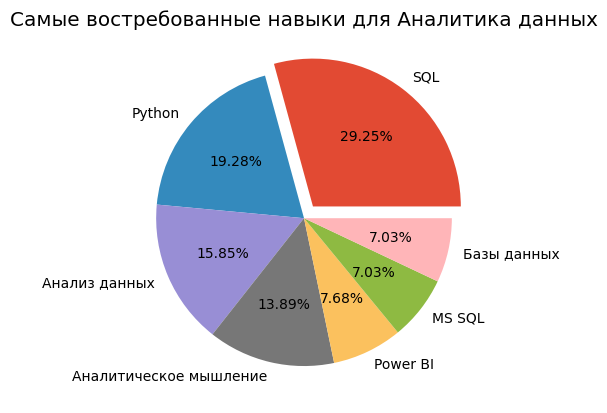

In [96]:
# Постройте график наиболее востребованных навыков
labels = count_skills_AD.index[0:7]
share = count_skills_AD.iloc[0:7]
explode = (0.1, 0, 0, 0, 0,0,0)
plt.style.use('ggplot')
plt.title('Самые востребованные навыки для Аналитика данных')
plt.pie(x = share, labels=labels, autopct='%.2f%%', explode=explode)
plt.show()


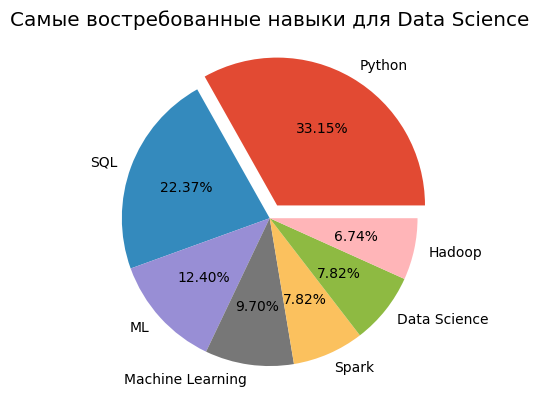

In [97]:

labels = count_skills_DS.index[0:7]
share = count_skills_DS.iloc[0:7]
explode = (0.1, 0, 0, 0, 0,0,0)
plt.style.use('ggplot')
plt.title('Самые востребованные навыки для Data Science')
plt.pie(x = share, labels=labels, autopct='%.2f%%', explode=explode)
plt.show()

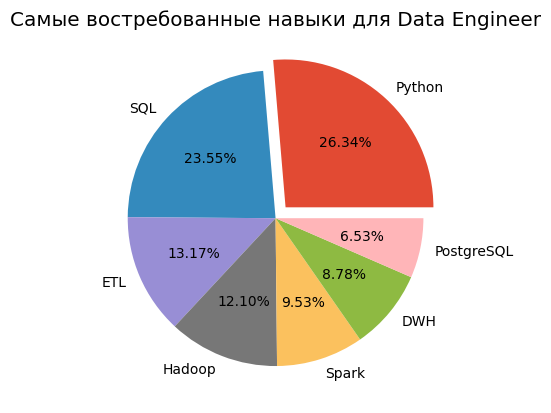

In [98]:

labels = count_skills_DE.index[0:7]
share = count_skills_DE.iloc[0:7]
explode = (0.1, 0, 0, 0, 0,0,0)
plt.style.use('ggplot')
plt.title('Самые востребованные навыки для Data Engineer')
plt.pie(x = share, labels=labels, autopct='%.2f%%', explode=explode)
plt.show()